## SCAO tip tilt map using Zernike covariance

In the following example, we plot the tip/tilt map that we expect from a SCAO configuration, i.e. correcting tip/tilt modes in the field of view with one NGS. \
The sources are elongated ellipses in the NGS's direction. Axes' length and orientation of each ellipse are obtained from tip/tilt covariance matrix computed between the NGS and the considered source.

In [133]:
def computeOffAxisError(covOnOn, covOnOff):
        return 2 * (covOnOn - covOnOff)
    
    
def getOffAxisErrorFromNGS(j_mode, k_mode,
                           distances_from_NGS, ngs_source,
                           ap1, ap2, profile, freqs_vector):
    vk = VonKarmanSpatioTemporalCovariance(source1=ngs_source, source2=ngs_source, aperture1=ap1, aperture2=ap2,
                                           cn2_profile=profile, spat_freqs=freqs_vector)
    ngs_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
    
    residualsList = []
    for coords in distances_from_NGS:
        source = GuideSource(coords, np.inf)
        vk.setSource2(source)
        on_off_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
        res = computeOffAxisError(ngs_covariance, on_off_covariance)
        residualsList.append(res)
    return residualsList


def ellipsePlot(distances_xy, width, height, angle,
                x_max, x_min, y_max, y_min):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    
    mpl.rcParams['figure.dpi'] = 150
    ellipse = [Ellipse((distances_xy[i, 0], distances_xy[i, 1]),
                       width[i]/2, height[i]/2, angle=angle[i]) for i in range(len(width))]
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for e in ellipse:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        
def getCartesianPositions(rho, theta):
    x = rho * np.cos(np.deg2rad(theta))
    y = rho * np.sin(np.deg2rad(theta))
    return x, y


def computeEllipseParameters(tip_tip_res, tilt_tilt_res, tip_tilt_res, nstd=1):
    covariance_matrix = np.array([[tip_tip_res, tip_tilt_res], [tip_tilt_res, tilt_tilt_res]])
    eig_values, eig_vectors = np.linalg.eigh(covariance_matrix)
    order = eig_values.argsort()[::-1]
    val_sort, vect_sort = eig_values[order], eig_vectors[:, order]
    theta = np.rad2deg(np.arctan2(vect_sort[:, 0][1], vect_sort[:, 0][0]))
    width, height = 2 * nstd * np.sqrt(val_sort)
    return width, height, theta

In [134]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
ngs = GuideSource((0, 0), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [-20])
cn2_profile.set_wavelength(2.2e-6)
spatial_freqs = np.logspace(-3, 3, 100)

#Definition of off-axis stars' positions.
rhos = np.random.randint(-50, 50, size=(500))
thetas = np.random.randint(360, size=(500))
positionsInPolar = np.stack((rhos, thetas), axis=-1)

#Computation of tip/tilt residuals.
res22 = getOffAxisErrorFromNGS(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res33 = getOffAxisErrorFromNGS(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res23 = getOffAxisErrorFromNGS(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)

print(res22[0])

0.822997142315975


Run this cell if you want to compute the residuals with CPSD too.

In [135]:
#from apposto.sandbox import ResidualVarianceUsingOneOffAxisNGS
#import astropy.units as u

#RTF = 0
#NTF = -1
#temp_freqs = np.linspace(0.05, 250, 5000)

#def getResidualFromCPSD(cpsd_on_on, cpsd_on_off, temp_freqs, noise=0, rtf=RTF, ntf=NTF):
#    var = ResidualVarianceUsingOneOffAxisNGS(rtf, ntf, cpsd_on_on, cpsd_on_off, noise)
#    res_with_cpsd = var.getResidualVariance(temp_freqs*u.Hz)
#    return res_with_cpsd.value

#def getOffAxisErrorFromNGSUsingCPSD(j_mode, k_mode, distances_from_NGS, ngs_source,
#                                    ap1, ap2, profile, freqs_vector, temp_vector):
#    vk = VonKarmanSpatioTemporalCovariance(source1=ngs_source, source2=ngs_source, aperture1=ap1, aperture2=ap2,
#                                           cn2_profile=profile, spat_freqs=freqs_vector)
#    cpsd_ngs = (vk.getZernikeCPSD(j_mode, k_mode, temp_vector).value).real
#    residualsList = []
#    for coords in distances_from_NGS:
#        source = GuideSource(coords, np.inf)
#        vk.setSource2(source)
#        cpsd_on_off = (vk.getZernikeCPSD(j_mode, k_mode, temp_vector).value).real
#        res = getResidualFromCPSD(cpsd_ngs, cpsd_on_off, temp_vector)
#        residualsList.append(res)
#    return residualsList

#res22_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
#                                      ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
#                                      freqs_vector=spatial_freqs, temp_vector=temp_freqs)
#res23_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
#                                      ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
#                                      freqs_vector=spatial_freqs, temp_vector=temp_freqs)
#res33_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
#                                      ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
#                                      freqs_vector=spatial_freqs, temp_vector=temp_freqs)

Text(0, 0.5, 'arcsec')

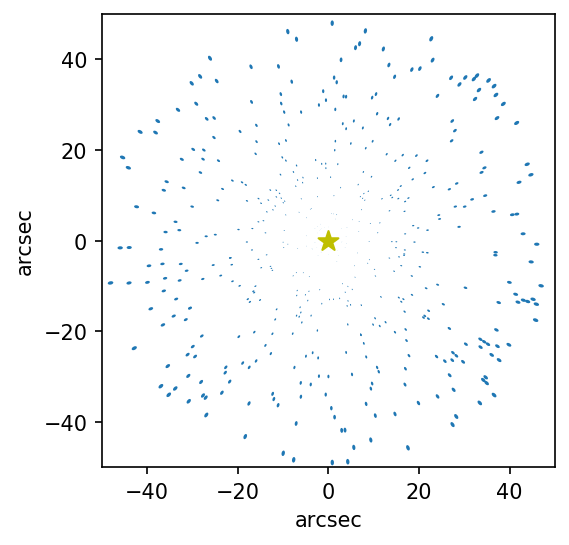

In [156]:
#Computation of covariance ellipses' parameters.
positionsInXY = np.stack(getCartesianPositions(rhos, thetas), axis=-1)
widths = []
heights = []
ths = []
for i in range(len(res22)):
    w, h, t = computeEllipseParameters(res22[i], res33[i], res23[i], nstd=1)
    widths.append(w)
    heights.append(h)
    ths.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=positionsInXY, width=widths, height=heights, angle=ths,
            x_max=50, x_min=-50, y_max=50, y_min=-50)

plt.scatter(0, 0, marker='*', s=100, color='y')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

## Test Sandler's formula for differential tilt jitter

We now verify if the computed ellipses follow the behavior of differential tilt jitter (i.e. if $\sigma_{\parallel} \sim \sqrt{3}\sigma_{\perp}$).

In [157]:
#widths_withCPSD = []
#heights_withCPSD = []
#ths_withCPSD = []
#for i in range(len(res22)):
#    w, h, t = computeEllipseParameters(res22[i], res33[i], res23[i])
#    widths_withCPSD.append(w/2)
#    heights_withCPSD.append(h/2)
#    ths_withCPSD.append(t)
    
#plt.figure()
#plt.plot(distancesFromNGS[order], np.array(widths_withCPSD)[order], '.', label="$\sigma_{\parallel}$")
#plt.plot(distancesFromNGS[order], np.array(heights_withCPSD)[order], '.',  label="$\sigma_{\perp}$")
#plt.xlabel('Distance from NGS [arcsec]')
#plt.ylabel('$\sigma$ [$rad_{\phi}]$')

#plt.plot(distancesFromNGS[order], np.array(widths)[order], '.', label="$\sigma_{\parallel}$")
#plt.plot(distancesFromNGS[order], np.array(heights)[order], '.',  label="$\sigma_{\perp}$")

0.0453783
6.132401647992238
6.025809888898929


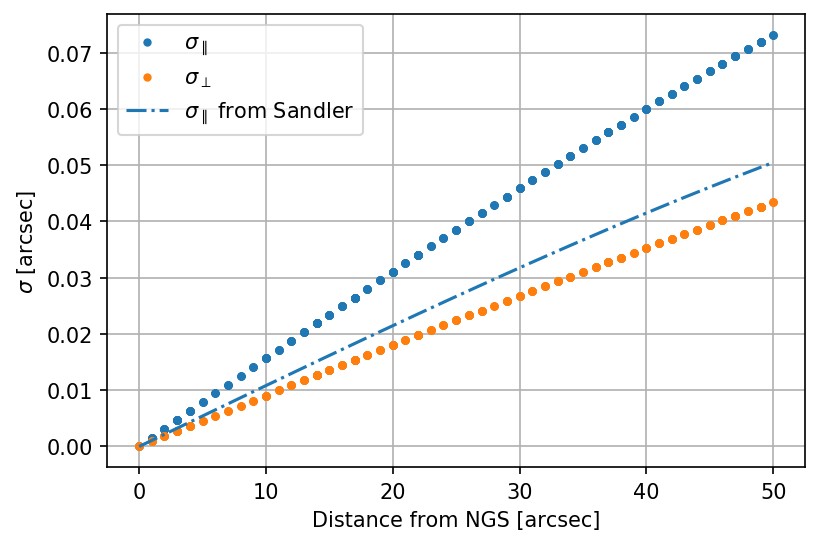

In [158]:
coordsNGS = np.stack((np.zeros(positionsInXY.shape[0]), np.zeros(positionsInXY.shape[0])), axis=-1)
distancesFromNGS = np.linalg.norm(coordsNGS - positionsInXY, axis=1)

order = distancesFromNGS.argsort()

D = 10
radToArcsec = 206265
wlength = cn2_profile.wavelength().value
r0 = cn2_profile.r0().value
theta0 = cn2_profile.theta0().value
th0 = 0.057 * wlength**(6/5)*cn2_profile.airmass()**(-8/5)* \
     (np.sum(cn2_profile._layersJs*cn2_profile._layersAltitudeInMeterAtZenith**(5/3)))**(-3/5) * radToArcsec

widthArcsec = np.array(widths) * 4 * wlength / (2 * np.pi) / D * radToArcsec
heightArcsec = np.array(heights) * 4 *wlength / (2 * np.pi) / D * radToArcsec

import matplotlib.pyplot as plt
plt.figure()
plt.plot(distancesFromNGS[order], widthArcsec[order], '.', label="$\sigma_{\parallel}$")
plt.plot(distancesFromNGS[order], heightArcsec[order], '.',  label="$\sigma_{\perp}$")
plt.xlabel('Distance from NGS [arcsec]')
plt.ylabel('$\sigma$ [arcsec]')

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
#m1 = 2/15
#m2 = np.sqrt(3) * m1
#plt.plot(distancesFromNGS[order], distancesFromNGS[order]*m2, color=cycle[0], label='$\sigma_{\parallel}$ from fit')
#plt.plot(distancesFromNGS[order], distancesFromNGS[order]*m1, color=cycle[1], label='$\sigma_{\perp}$ from fit')

m3 = 0.0472 * (D/r0)**(-1/3) / (theta0**2)
#m4 = np.sqrt(0.0157) * r0**(1/6) / (theta0 * D**(1/6)) 
m5 = -0.0107 * r0**(7/3) / (theta0**4 * D**(7/3)) 
mPar = np.sqrt(distancesFromNGS[order]**2*m3 + distancesFromNGS[order]**4*m5) * wlength / D * radToArcsec
plt.plot(distancesFromNGS[order], mPar, '-.', color = cycle[0], label='$\sigma_{\parallel}$ from Sandler')
#plt.plot(distancesFromNGS[order], distancesFromNGS[order]*m4, '-.', color=cycle[1], label='$\sigma_{\perp}$ from Sandler')
plt.legend()
plt.grid()


print(wlength/D * radToArcsec)
print(theta0)
print(th0)


## Residual from CPSD

In [94]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
target = GuideSource((0, 0), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [-20])
spatial_freqs = np.logspace(-4, 4, 1000)
temp_freqs = np.logspace(-3, 3, 1000)

vk = VonKarmanSpatioTemporalCovariance(source1=target, source2=target, aperture1=aperture1, aperture2=aperture2,
                                           cn2_profile=cn2_profile, spat_freqs=spatial_freqs)

cov_on_on = vk.getZernikeCovariance(2, 2)
cpsd_on_on = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)

ngs = GuideSource((50,30), np.inf)
vk.setSource2(ngs)
cov_on_off = vk.getZernikeCovariance(2, 2)
cpsd_on_off = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)

In [95]:
res_with_cov = 2 * (cov_on_on - cov_on_off)

from apposto.sandbox import ResidualVarianceUsingOneOffAxisNGS
import astropy.units as u
RTF = 0
NTF = -1
var = ResidualVarianceUsingOneOffAxisNGS(RTF, NTF, cpsd_on_on, cpsd_on_off, 0)
res_with_cpsd = var.getResidualVariance(temp_freqs*u.Hz)

In [96]:
print('Residual from covariance: {}'.format(res_with_cov))
print('Residual from CPSD and TF: {}'.format(res_with_cpsd))
print('Ratio: {}'.format(res_with_cov/res_with_cpsd))

Residual from covariance: (25.9466544734222+0j) rad2
Residual from CPSD and TF: (25.913265528506056+0j) rad2
Ratio: (1.0012884885110067+0j)
